In [2]:
import pandas as pd
import numpy as np
import glob as gb
import re
import itertools as it
from sklearn.linear_model import LogisticRegression
from PIL import Image as ig
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from utils import create_submission, rle_encoding

In [3]:
img_train = pd.read_csv("comp-540-spring-2019/train.csv")
#print(gb.glob("comp-540-spring-2019/train/*.jpg"))

In [4]:
#loading .jpg

img1 = ig.open("comp-540-spring-2019/train/50484_sat.jpg")
img1_RGB = img1.convert('RGB')

img1_msk = ig.open("comp-540-spring-2019/train/50484_msk.png")
img1_msk_RGB = img1_msk.convert('RGB')


In [5]:
img1_RGB.getpixel((0,200))

(135, 106, 74)

In [6]:
img1_msk_RGB.getpixel((0,200))

(0, 0, 0)

In [18]:
np.array(img1).flatten().reshape((512, 512, 3))

array([[[142, 122,  89],
        [143, 123,  90],
        [148, 128,  95],
        ...,
        [131, 107,  81],
        [117,  93,  67],
        [101,  77,  51]],

       [[147, 127,  94],
        [146, 126,  93],
        [149, 129,  96],
        ...,
        [130, 106,  80],
        [117,  93,  67],
        [102,  78,  52]],

       [[147, 128,  95],
        [146, 127,  94],
        [149, 130,  97],
        ...,
        [130, 106,  80],
        [120,  96,  70],
        [107,  83,  57]],

       ...,

       [[124, 109,  78],
        [119, 104,  73],
        [115, 100,  71],
        ...,
        [154, 134,  97],
        [151, 131,  94],
        [149, 129,  92]],

       [[121, 106,  75],
        [118, 103,  72],
        [117, 102,  71],
        ...,
        [149, 129,  92],
        [150, 130,  93],
        [151, 131,  94]],

       [[109,  94,  63],
        [110,  95,  64],
        [113,  98,  67],
        ...,
        [149, 129,  92],
        [151, 131,  94],
        [155, 135,  98]]

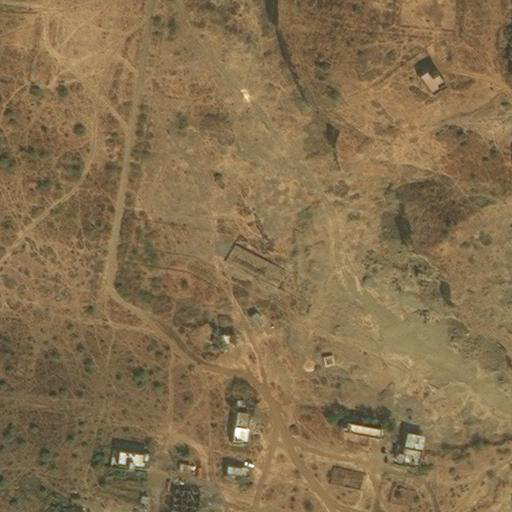

In [8]:
img1

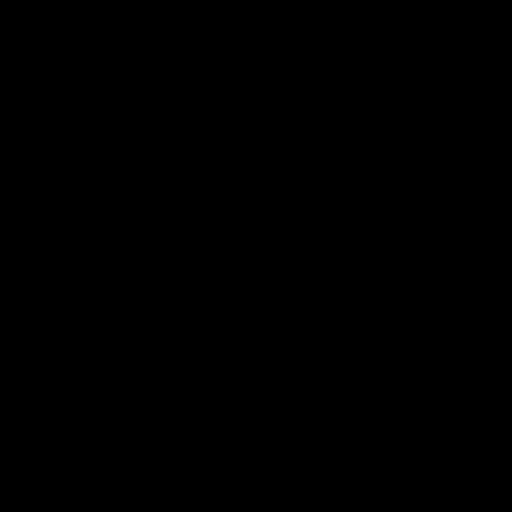

In [9]:
img1_msk

In [ ]:
%%time

num_of_imgs = 15
height = 512
width = 512
indices = range(0, (num_of_imgs * height * width))
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
train_df = pd.DataFrame(index = indices, columns = columns)
img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))
img_nums = img_nums[:num_of_imgs]


np.array(img1).flatten()

In [15]:
%%time
#loading all images

num_of_imgs = 15
height = 512
width = 512
indices = range(0, (num_of_imgs * height * width))
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
train_df = pd.DataFrame(index = indices, columns = columns)
img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))
img_nums = img_nums[:num_of_imgs]

train_df.loc[:, 'ImageNumber'] = np.repeat(img_nums, height * width)
train_df.loc[:, 'Height'] = np.repeat(np.repeat(range(0, height), width), num_of_imgs)
train_df.loc[:, 'Width'] = list(range(0, width)) * (num_of_imgs * height)

for img_num in range(0, num_of_imgs, 1):
    img = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_sat.jpg")
    msk = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_msk.png")
    img_mat = list(img.getdata())
    msk_mat = list(msk.getdata())
    train_df.loc[(img_num * height * width):(((img_num + 1) * height * width) - 1), 'R':'B'] = img_mat
    train_df.loc[(img_num * height * width):(((img_num + 1) * height * width) - 1), 'Mask'] = np.array(msk_mat)[:, 1]

train_df["Lightness"] = (train_df[["R", "G", "B"]].max(axis = 1) + train_df[["R", "G", "B"]].max(axis = 1)) / 2
train_df.Road = (train_df.Mask > 0)


CPU times: user 38.3 s, sys: 4.36 s, total: 42.6 s
Wall time: 43.4 s


In [13]:
#loading all images - batches

num_of_imgs = 100
height = 512
width = 512
indices = range(0, (height * width))
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
train_df = pd.DataFrame(index = [0], columns = columns)
img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))
img_nums = img_nums[:num_of_imgs]

for img_num in range(0, num_of_imgs, 1):
    img = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_sat.jpg")
    msk = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_msk.png")
    img_mat = list(img.getdata())
    msk_mat = list(msk.getdata())
    temp_df = pd.DataFrame(index = indices, columns = columns)
    temp_df["ImageNumber"] = np.repeat(img_nums[img_num], height * width)
    temp_df["Height"] = np.repeat(range(0, height), width)
    temp_df["Width"] = list(range(0, width)) * height
    temp_df[["R", "G", "B"]] = img_mat
    temp_df["Mask"] = np.array(msk_mat)[:, 1]
    train_df = train_df.append(temp_df)

train_df["Lightness"] = (train_df[["R", "G", "B"]].max(axis = 1) + train_df[["R", "G", "B"]].max(axis = 1)) / 2
train_df.Road = (train_df.Mask > 0)

In [13]:

print(len(train_df.ImageNumber.unique()))
print(train_df)

10
        ImageNumber  Height  Width    R    G   B  Lightness  Mask   Road
0              7446       0      0  153  142  96      153.0     0  False
1              7446       0      1  156  145  99      156.0     0  False
2              7446       0      2  155  144  98      155.0     0  False
3              7446       0      3  152  141  95      152.0     0  False
4              7446       0      4  153  142  96      153.0     0  False
5              7446       0      5  156  145  99      156.0     0  False
6              7446       0      6  154  143  97      154.0     0  False
7              7446       0      7  149  138  92      149.0     0  False
8              7446       0      8  153  142  96      153.0     0  False
9              7446       0      9  155  144  98      155.0     0  False
10             7446       0     10  155  144  98      155.0     0  False
11             7446       0     11  153  142  96      153.0     0  False
12             7446       0     12  149  138  92

In [18]:
#Simple model

train_df['RoadBool'] = train_df.Road * 1

logreg = LogisticRegression()
#X_train = train_df[['R', 'G', 'B']]
#y_train = train_df['RoadBool']

X_train, X_test, y_train, y_test = train_test_split(train_df[['R', 'G', 'B', 'Lightness']], train_df['RoadBool'], test_size = 0.20)

#knn = KNeighborsClassifier(n_neighbors = 5)
#knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)

lgfit = logreg.fit(X_train, y_train)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [14]:
#lgfit.score(X_train, y_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5058887   15696]
 [ 161661    6636]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98   5074583
          1       0.30      0.04      0.07    168297

avg / total       0.95      0.97      0.95   5242880



5242880

NameError: name 'X_train' is not defined

In [ ]:
#Just in case

for img_num in range(0, num_of_imgs, 1):
    img = ig.open("comp-540-spring-2019/train/" + str(10000 + img_num + 1) + "_sat.jpg")
    msk = ig.open("comp-540-spring-2019/train/" + str(10000 + img_num + 1) + "_msk.png")
    img_RGB = img.convert('RGB')
    msk_RGB = msk.convert('RGB')
    for h in range(0, 512):
        print(h)
        for w in range(0, 512):
            print(w)
            row_num = (((h * 512) + w) + (img_num * height * width))
            train_df.loc[row_num, 'ImageNumber'] = img_num + 1
            train_df.loc[row_num, 'Height'] = h
            train_df.loc[row_num, 'Width'] = w
            RGB = img_RGB.getpixel((h, w))
            train_df.loc[row_num, 'R':'B'] = RGB
            train_df.loc[row_num, 'Lightness'] = (max(RGB) + min(RGB)) / 2
            train_df.loc[row_num, 'Road'] = (msk_RGB.getpixel((h, w))[0] > 0)